# Supplementary Figure1

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import differential_evolution
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
getwd = os.getcwd()
getwd

'/home/hiroki578/Usersdata2/Kasai/Doctor/b16_act_analysis/code/ode'

# Fig. S1: Tumor growth dynamics in untreated mice

In [3]:
dir_path = "../../results/figures/section1/figS1/"
os.makedirs(dir_path, exist_ok=True)

## 1. Load tumor volume data

In [4]:
df = pd.read_csv('../../data/tumor/B16F10.csv')
B16F10 = df[df['day'] != -9].copy()
# Convert 'tumor_volume' column to numeric type
B16F10['tumor_volume'] = pd.to_numeric(B16F10['tumor_volume'], errors='coerce')

In [5]:
# Get unique conditions and experiments
unique_conditions = B16F10['Condition'].unique()
unique_experiments = B16F10['Experiment'].unique()

# Assign consistent colors to experiments
experiment_colors = {
    experiment: color for experiment, color in zip(
        unique_experiments, 
        sns.color_palette("tab10", len(unique_experiments))
    )
}

In [6]:
B16F10

,Experiment,Condition,id,day,tumor_volume
0,Hosoi_2014_Fig1a,Untreated,1,-1,7.6
1,Hosoi_2014_Fig1a,Untreated,2,-1,17.4
2,Hosoi_2014_Fig1a,Untreated,3,-1,13.5
3,Hosoi_2014_Fig1a,Untreated,4,-1,12.2
4,Hosoi_2014_Fig1a,Untreated,5,-1,28.4
...,...,...,...,...,...
737,Hirano_2015_Fig4a,TST+anti-PD1+CPTIO,2,15,671.1
738,Hirano_2015_Fig4a,TST+anti-PD1+CPTIO,3,15,508.4
739,Hirano_2015_Fig4a,TST+anti-PD1+CPTIO,4,15,1692.3
740,Hirano_2015_Fig4a,TST+anti-PD1+CPTIO,5,15,624.3


In [7]:
unique_mice = B16F10.drop_duplicates(subset=["Experiment", "Condition", "id"])
mouse_counts = unique_mice.groupby(["Experiment", "Condition"]).size().reset_index(name="mouse_count")
mouse_counts

,Experiment,Condition,mouse_count
0,Hirano_2015_Fig1a,CPTIO_Day1-5,6
1,Hirano_2015_Fig1a,TST,5
2,Hirano_2015_Fig1a,TST+CPTIO_Day1-5,6
3,Hirano_2015_Fig1a,Untreated,5
4,Hirano_2015_Fig4a,CPTIO,5
5,Hirano_2015_Fig4a,TST,7
6,Hirano_2015_Fig4a,TST+CPTIO,6
7,Hirano_2015_Fig4a,TST+anti-PD1,7
8,Hirano_2015_Fig4a,TST+anti-PD1+CPTIO,6
9,Hirano_2015_Fig4a,Untreated,7


## 2. Function of tumor volume and growth¶

In [8]:
# Compute mean +- SD of tumor volume for a given treatment
def tumor_volume(B16F10, treatment):
    Treat = B16F10[(B16F10['Condition'] == treatment)] 
    return Treat.groupby('day')['tumor_volume'].agg(['mean','std']).reset_index()

# Compute tumor growth rate per day (log scale)
def growth_ratio(B16F10, treatment):
    B16_Cond = B16F10[(B16F10['Condition'] == treatment)].copy()
    B16_Cond['Experiment_id'] = B16_Cond['Experiment'] + "_" + B16_Cond['id'].astype(str)
    B16_grouped = B16_Cond.groupby('Experiment_id')
    # Compute the midpoint between consecutive day
    B16_Cond['day_average'] = B16_grouped['day'].shift(1).add(B16_Cond['day']).div(2)
    # Compute the log-scale tumor grwoth rate between two time points
    B16_Cond['change_ratio'] = np.log(B16_Cond['tumor_volume'] / B16_grouped['tumor_volume'].shift(1)) / (B16_Cond['day'] - B16_grouped['day'].shift(1))
    B16_Cond = B16_Cond.dropna()
    B16_ratio = B16_Cond.groupby('day_average')['change_ratio'].agg(['mean', 'std']).reset_index()
    return B16_ratio

In [9]:
# Initialize an empty list to store per-mouse growth rates
growth_rate_data = []

# Iterate over each condition and experiment to calculate growth rate
for condition in unique_conditions:
    condition_data = B16F10[B16F10['Condition'] == condition]
    
    for experiment in unique_experiments:
        experiment_data = condition_data[condition_data['Experiment'] == experiment]
        
        for mouse_id in experiment_data['id'].unique():
            mouse_data = experiment_data[experiment_data['id'] == mouse_id]
            mouse_data = mouse_data[mouse_data['tumor_volume'] > 0].sort_values(by='day')  # Remove V(t) = 0 and sort by day
            
            # Calculate growth rate
            for i in range(len(mouse_data) - 1):
                day_t = mouse_data.iloc[i]['day']
                day_t_plus_s = mouse_data.iloc[i + 1]['day']
                volume_t = mouse_data.iloc[i]['tumor_volume']
                volume_t_plus_s = mouse_data.iloc[i + 1]['tumor_volume']
                s = day_t_plus_s - day_t
                
                # Avoid division by zero or invalid log
                if volume_t > 0 and volume_t_plus_s > 0:
                    growth_rate = (1 / s) * np.log(volume_t_plus_s / volume_t)
                    avg_day = (day_t + day_t_plus_s) / 2
                    growth_rate_data.append({
                        'Condition': condition,
                        'Experiment': experiment,
                        'id': mouse_id,
                        'day_average': avg_day,
                        'growth_rate': growth_rate
                    })

# Convert growth rate data into a DataFrame
growth_rate_df = pd.DataFrame(growth_rate_data)

# Fig. S1a Untreated tumor cells

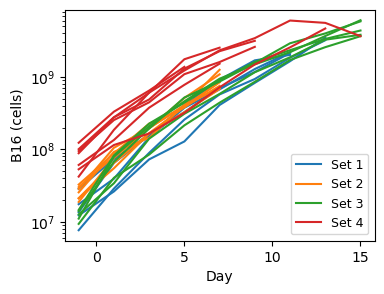

In [10]:
# Compute mean and standard deviation of tumor volume for untreated condition
unt_average = tumor_volume(B16F10, 'Untreated')

# Plot tumor volume trajectories (log scale) for the 'Untreated' condition
for condition in np.array(['Untreated']):
    plt.figure(figsize=(4, 3))
    condition_data = B16F10[B16F10['Condition'] == condition]
    
    # Plot each experiment froup using a consistent color map
    i=0
    for experiment in unique_experiments:
        i=i+1
        experiment_data = condition_data[condition_data['Experiment'] == experiment]
        
        # Plot each individual mouse id in the experiment
        for mouse_id in experiment_data['id'].unique():
            mouse_data = experiment_data[experiment_data['id'] == mouse_id]
            plt.plot(mouse_data['day'], 
                     mouse_data['tumor_volume']*1e6, # Convert mm³ to number of B16 cells
                     label=f'Set {i}' if mouse_id == 1 else "", # Label only once per experiment
                     color=experiment_colors[experiment])
    plt.yscale('log')
    plt.xlabel('Day')
    plt.ylabel('B16 (cells)')
    plt.legend(fontsize=9)

plt.savefig(os.path.join(dir_path, 'a_untreated_tumor_cells.pdf'), bbox_inches='tight', dpi=1200)


# Fig. S1b Untreated tumor growth

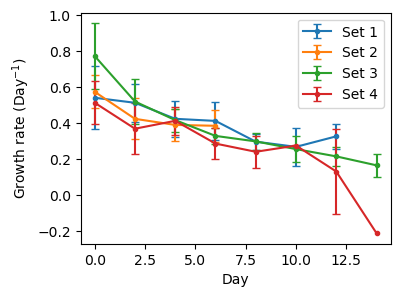

In [11]:
# Plot average tumor growth rate ± standard deviation for the 'Untreated' condition
for condition in np.array(['Untreated']):
    plt.figure(figsize=(4, 3))
    
    # Filter growth rate data for the current condition
    condition_growth_data = growth_rate_df[growth_rate_df['Condition'] == condition]
    
    # Compute mean and standard deviation of growth rate per avg_day and experiment
    mean_std_growth_data = condition_growth_data.groupby(['day_average', 'Experiment']).agg(
        avg_growth_rate=('growth_rate', 'mean'),
        std_growth_rate=('growth_rate', 'std')
    ).reset_index()
    
    # Plot average growth rate ± SD for each experiment
    i = 0
    for experiment in unique_experiments:
        i+=1
        experiment_data = mean_std_growth_data[mean_std_growth_data['Experiment'] == experiment]
        plt.errorbar(
            experiment_data['day_average'],
            experiment_data['avg_growth_rate'],
            yerr=experiment_data['std_growth_rate'],
            fmt='-o', markersize=3, capsize=3,
            #label=f'{experiment}',
            label=f'Set {i}',
            color=experiment_colors[experiment]
        )
    
    # Label axes
    plt.xlabel('Day')
    plt.ylabel('Growth rate (Day$^{-1}$)')
    plt.legend(fontsize=10)
plt.savefig(os.path.join(dir_path, 'b_untreated_tumor_growth.pdf'), bbox_inches='tight', dpi=1200)


# Fig. S1c-f

## 1. Data extraction: Untreated group

In [12]:
# Extract untreated condition data
untreated_data = B16F10[B16F10['Condition'] == 'Untreated'].reset_index(drop=True)
untreated_data['tumor_cells']=untreated_data['tumor_volume']*1e6 # Cell number
# Extract growth rate data for untreated condition
untreated_data_growth = growth_rate_df[growth_rate_df['Condition'] == 'Untreated'].reset_index(drop=True)

# Define training and validation experiment sets
train_set = ['Hosoi_2014_Fig1a', 'Hirano_2015_Fig1a', 'Hosoi_2014_Fig5a']
valid_set = ['Hirano_2015_Fig4a']
# Split untreated data into training and validation sets
unt_train = untreated_data[untreated_data['Experiment'].isin(train_set)]
unt_valid = untreated_data[untreated_data['Experiment'].isin(valid_set)]

In [13]:
# Train data
unt_train_grouped = unt_train.groupby('day')['tumor_cells'].agg(['mean', 'std']).reset_index()
unt_train_time = unt_train_grouped['day'].values
unt_train_mean = unt_train_grouped['mean'].values
unt_train_std = unt_train_grouped['std'].values

In [14]:
# Validation data
unt_valid_grouped = unt_valid.groupby('day')['tumor_cells'].agg(['mean', 'std']).reset_index()
unt_valid_time = unt_valid_grouped['day'].values
unt_valid_mean = unt_valid_grouped['mean'].values
unt_valid_std = unt_valid_grouped['std'].values

## 2. Parameter optimization

### ODE function

In [15]:
# Gompertz
def gompertz_model(V, t, r, K):
    return r * V * np.log(K / V)
def gompertz_solve(t, r, K, V0):
    return odeint(gompertz_model, V0, t, args=(r, K)).ravel()

# Logistic
def logistic_model(V, t, r, K):
    return r * V * (1-V/K)
def logistic_solve(t, r, K, V0):
    return odeint(logistic_model, V0, t, args=(r, K)).ravel()

# Exponential
def exponential_model(V, t, r):
    return r * V
def exponential_solve(t, r, V0):
    return odeint(exponential_model, V0, t, args=(r,)).ravel()

### Parameter optimization using differential evolution

In [16]:
def weighted_error(params, model_solve, time_data, mean_volume_data, std_dev_data):
    V0 = mean_volume_data[0]
    model_pred = model_solve(time_data, *params, V0)
    return np.sum(((mean_volume_data - model_pred) / std_dev_data) ** 2)

def param_opt_de(model_solve, bounds, time_data, mean_volume_data, std_dev_data):
    """
    Estimate parameters by minimizing the weighted error 
    using differential evolution.
    """
    result = differential_evolution(
        weighted_error, 
        bounds, 
        args = (model_solve, time_data, mean_volume_data, std_dev_data),
        seed = 12
    )
    return result.x

In [17]:
# Define parameter bounds for each model
gompertz_bounds = [(0, 1), (1e8, 1e12)] # [growth_rate, carrying_capacity]
logistic_bounds = [(0, 1), (1e8, 1e12)] # [growth_rate, carrying_capacity]
exponential_bounds = [(0, 1)]           # [growth_rate only]

params_gompertz = param_opt_de(gompertz_solve, gompertz_bounds, unt_train_time, unt_train_mean, unt_train_std)
params_logistic = param_opt_de(logistic_solve, logistic_bounds, unt_train_time, unt_train_mean, unt_train_std)
params_exponential = param_opt_de(exponential_solve, exponential_bounds, unt_train_time, unt_train_mean, unt_train_std)

print(f"Gompertz : {params_gompertz}")
print(f"Logistic : {params_logistic}")
print(f"Exponential: {params_exponential}")

Gompertz : [8.53176784e-02 3.14349460e+10]
Logistic : [4.69055728e-01 4.42690040e+09]
Exponential: [0.36983587]


## 3. Fitting results

### Figure S1C Fitting results

In [18]:
# Fitting Simulation
time_sim = np.arange(-1, 15.1, 0.1)
fit_gompertz = gompertz_solve(time_sim, *params_gompertz, unt_train_mean[0])
fit_logistic = logistic_solve(time_sim, *params_logistic, unt_train_mean[0])
fit_exponential = exponential_solve(time_sim, *params_exponential, unt_train_mean[0])

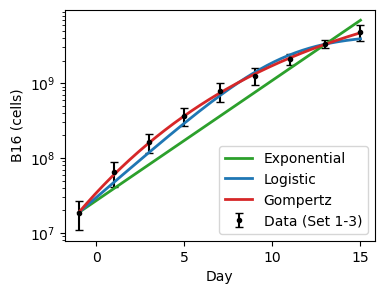

In [19]:
# plot
plt.figure(figsize=(4, 3))

# experimental data
plt.errorbar(unt_train_time, unt_train_mean, yerr=unt_train_std, color = 'black',
             capsize=3, markersize=3, fmt='o', label='Data (Set 1-3)')

# fitting
plt.plot(time_sim, fit_exponential, label='Exponential', color='tab:green',linewidth=2)
plt.plot(time_sim, fit_logistic, label='Logistic', color='tab:blue',linewidth=2)
plt.plot(time_sim, fit_gompertz, label='Gompertz', color='tab:red',linewidth=2)

plt.yscale('log')
plt.xlabel('Day')
plt.ylabel('B16 (cells)')
plt.legend()
plt.savefig(os.path.join(dir_path, 'c_fitting_simulation.pdf'), bbox_inches='tight', dpi=1200)

## 4. Model fitting performance evaluation

### Function of evaluation

In [20]:
# Compute RMSE and AIC for each model
def evaluate_model(model_solve, params, time_data, mean_volume_data, std_dev_data):
    """
    Evaluate model fit using RMSE and AIC.
    Inputs:
        - model_solve: function to solve the model
        - params: fitted model parameters
        - time_data: time points (days)
        - mean_volume_data: observed tumor volume means
        - std_dev_data: standard deviation of tumor volumes
    Returns:
        - rmse: root mean squared error (weighted)
        - aic: Akaike information criterion
        - model_fit: model prediction at time points
    """
    V0 = mean_volume_data[0]  # initial tumor volume
    model_fit = model_solve(time_data, *params, V0)

    # Weighted RMSE using inverse variance
    rmse = np.sqrt(mean_squared_error(mean_volume_data, model_fit, sample_weight=1 / std_dev_data**2))

    # Residual sum of squares (weighted)
    rss = np.sum(((mean_volume_data - model_fit) / std_dev_data) ** 2)

    # AIC: n * log(RSS / n) + 2 * k
    n = len(mean_volume_data)  # number of data points
    k = len(params)            # number of parameters
    aic = n * np.log(rss / n) + 2 * k

    return rmse, aic, model_fit

In [21]:
# Evaluate fitting performance for each model
rmse_gompertz, aic_gompertz, fit_gompertz = evaluate_model(
    gompertz_solve, params_gompertz, unt_train_time, unt_train_mean, unt_train_std
)
rmse_logistic, aic_logistic, fit_logistic = evaluate_model(
    logistic_solve, params_logistic, unt_train_time, unt_train_mean, unt_train_std
)
rmse_exponential, aic_exponential, fit_exponential = evaluate_model(
    exponential_solve, params_exponential, unt_train_time, unt_train_mean, unt_train_std
)

### Comparison of RMSE across models

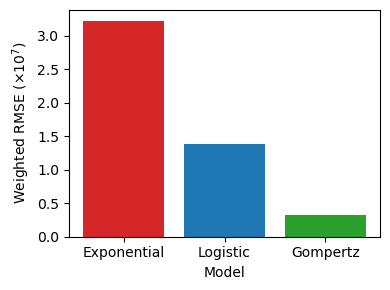

In [42]:
models = ['Exponential', 'Logistic', 'Gompertz', ]
rmse_values = [rmse_exponential/1e7, rmse_logistic/1e7, rmse_gompertz/1e7]
colors = ['tab:red', 'tab:blue', 'tab:green']

plt.figure(figsize=(4, 3))
plt.bar(models, rmse_values, color=colors)
plt.xlabel('Model')
plt.ylabel(r'Weighted RMSE ($\times 10^7$)')
plt.tight_layout()
plt.show()

### Fig. S1d Comparison of AIC across models

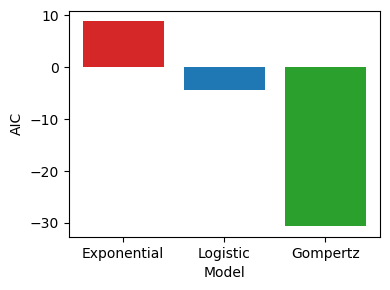

In [23]:
aic_values = [aic_exponential, aic_logistic, aic_gompertz]

plt.figure(figsize=(4, 3))
plt.bar(models, aic_values, color=colors)
plt.xlabel('Model')
plt.ylabel('AIC')
plt.tight_layout()
plt.savefig(os.path.join(dir_path, 'd_AIC_comparison.pdf'), bbox_inches='tight', dpi=1200)

## 5. Validation

### Fig. S1e Model predictions versus validation data

In [24]:
time_sim = np.arange(-1, 15.1, 0.1)

fit_gompertz_valid = gompertz_solve(time_sim, *params_gompertz, unt_valid_mean[0])
fit_logistic_valid = logistic_solve(time_sim, *params_logistic, unt_valid_mean[0])
fit_exponential_valid = exponential_solve(time_sim, *params_exponential, unt_valid_mean[0])

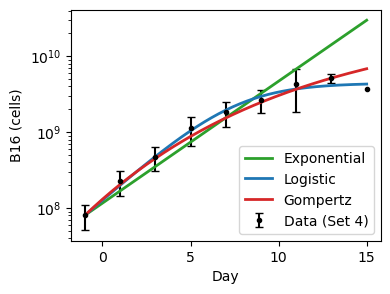

In [25]:
plt.figure(figsize=(4, 3))

# Validation data
plt.errorbar(unt_valid_time, unt_valid_mean, yerr=unt_valid_std, color='black',
             capsize=3, markersize=3, fmt='o', label='Data (Set 4)')

# Model predictions
plt.plot(time_sim, fit_exponential_valid, label='Exponential', color='tab:green', linewidth=2)
plt.plot(time_sim, fit_logistic_valid, label='Logistic', color='tab:blue', linewidth=2)
plt.plot(time_sim, fit_gompertz_valid, label='Gompertz', color='tab:red', linewidth=2)

plt.yscale('log')
plt.xlabel('Day')
plt.ylabel('B16 (cells)')
plt.legend(loc='lower right')
plt.savefig(os.path.join(dir_path, 'e_validation_simulation.pdf'), bbox_inches='tight', dpi=1200)

### Fig. S1f Model fit evaluation on validation data (mean only)
Exclude day 15 from validation data due to having only a single data point

In [26]:
# RMSE, MAE, R^2
def validate_model(model_solve, params, time_data, mean_volume_data, std_dev_data):
    """
    Compute validation metrics: RMSE, MAE, R^2
    Excludes last data point (day 15) due to insufficient replicates.
    """
    V0 = mean_volume_data[0]
    model_fit = model_solve(time_data, *params, V0)
    rmse = np.sqrt(mean_squared_error(mean_volume_data[:-1], model_fit[:-1], 
                                      sample_weight=1/std_dev_data[:-1]**2))
    mae = mean_absolute_error(mean_volume_data[:-1], model_fit[:-1])
    r2 = r2_score(mean_volume_data[:-1], model_fit[:-1])
    return rmse, mae, r2

rmse_gompertz_valid, mae_gompertz_valid, r2_gompertz_valid = validate_model(
    gompertz_solve, params_gompertz, unt_valid_time, unt_valid_mean, unt_valid_std
)
rmse_logistic_valid, mae_logistic_valid, r2_logistic_valid = validate_model(
    logistic_solve, params_logistic, unt_valid_time, unt_valid_mean, unt_valid_std
)
rmse_exponential_valid, mae_exponential_valid, r2_exponential_valid = validate_model(
    exponential_solve, params_exponential,unt_valid_time, unt_valid_mean, unt_valid_std
)

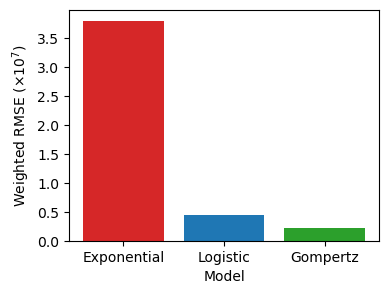

In [41]:
# --- Visualization: RMSE ---
models = ['Exponential', 'Logistic', 'Gompertz']
rmse_values = [rmse_exponential_valid/1e8, rmse_logistic_valid/1e8, rmse_gompertz_valid/1e8]

plt.figure(figsize=(4, 3))
plt.bar(models, rmse_values, color=['tab:red', 'tab:blue', 'tab:green'])
plt.xlabel('Model')
plt.ylabel(r'Weighted RMSE ($\times 10^7$)')
plt.show()

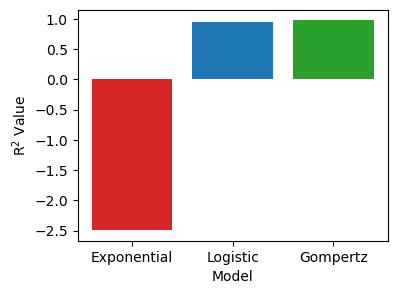

In [30]:
# --- Visualization: R² ---
r2_values = [r2_exponential_valid, r2_logistic_valid, r2_gompertz_valid]

plt.figure(figsize=(4, 3))
plt.bar(models, r2_values, color=['tab:red', 'tab:blue', 'tab:green'])
plt.xlabel('Model')
plt.ylabel('R$^2$ Value')

plt.savefig(os.path.join(dir_path, 'f_validation_r2_comparison.pdf'), bbox_inches='tight', dpi=1200)